In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.integrate import quad, nquad, dblquad
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
from pathlib import Path
import pickle as pkl
import glob
import os
fig_path = Path('/home/adameshel/Documents/code/autocorr/figures/')
my_path = Path('/home/adameshel/Documents/code/autocorr/TRY/')
# from autocorr_functions import *

In [3]:
import autocorr_cmls as accml
def split_at(s, c, n):
    '''Function for splitting strings (first arg). The last argument is the position of the
        selected seperator (second arg) in the string.'''
    words = s.split(c)
    return c.join(words[:n]), c.join(words[n:])

In [179]:
full_expr = False # Full or simplified expression
alpha_beta_95 = False # When false alpha and beta are optimized
printing = True

In [183]:
def acf_original(h, alpha, beta):
    return beta * np.exp(-(h/alpha))

def acf_original_gamma(h, alpha, beta, gamma=1.0):
    return beta * np.exp(-(h/alpha)**gamma)

def acf(t1,t2,h,L,theta,phi=-999):
    '''Auto-Correlation Function'''
    # the full expression under the sqrt
    if phi != -999: 
        sq = t2**2 + (h/L)**2 + 2*t2*(h/L)*np.cos(theta-phi) +\
        t1**2 -2*t1*(t2*np.sin(theta)+(h/L)*np.sin(phi)) + 1e-8
    # the short expression where theta=phi
    else: 
        sq = (t2+(h/L))**2 + t1**2 -2*t1*(t2+(h/L))*np.sin(theta) + 1e-8
    if sq < 0:
        print(sq, theta, phi)
    return beta * np.exp(-((L * np.sqrt(sq)) / alpha)**gamma)

def Rr_ang(h,L,thetas,phis,full_expr=False):
    '''Function that loops over thetas and returns 
    the solution to the double integral of acf, for the simplified expression,
    where theta equals phi (False) and for the full one (True).'''
    rs = []
    if full_expr is False:
        phis = np.array([-999])  
    for theta in thetas:
        r = []
        for phi in phis:    
            # perform the double integral
            result, err = nquad(acf,[[-0.5,0.5],[-0.5,0.5]],args=(h,L,theta,phi))#,
#                                 opts=[{'epsabs' : 1.49e-1,
#                                        'epsrel' : 1.49e-1,
#                                        'limit' : 2},
#                                       {'epsabs' : 1.49e-1,
#                                        'epsrel' : 1.49e-1,
#                                        'limit' : 2},
#                                       {},{}])
            r.append(result)
        r = np.array(r)
        rs.append(r)
    rs = np.array(rs)
    return rs, np.nanmean(rs) 

def compute_acf(hs,L,pic=0,printing=False):
    avgs = []
    i = 0; j = 0
    c = np.linspace(0.0,1.2,int(len(hs)/3)+1)
    for h in hs:
        acf_theta, avg = Rr_ang(h,L,thetas,phis,full_expr=full_expr) 
        avgs.append(avg)
        if printing and i%3==0:
            temp = h/L
            col = (c[j]/1.5, c[j]/1.5, c[j]/1.5)
            j += 1
            ax[pic].plot(thetas, acf_theta, color=col, label='h/L=%.2f' %temp)
        i += 1
    return np.array(avgs)

def alpha_L(x,a,alpha_0):
    '''x is a (2,N) array with L and gamma_L'''
#     return alpha_0 + a*x[0]**(1+(a*x[1]))
    return a*x[0]*(x[1]) + alpha_0

def beta_L(x,b,beta_0):
    return beta_0*np.exp(-x/(b*alpha_0))
#     return alpha_0*b*x + beta_0

def gamma_L(x,c1,c2):
#     return c*x + 1
    return c1*x**c2 + 1

def alpha_L_inv(x,a,alpha,bias=0):
    '''x is a (2,N) array with L and gamma_L'''
#     alpha_0 = alpha - a*x[0]**(1+(a*x[1]))
    alpha_0 = alpha - a*x[0]*(x[1]) - bias
    return alpha_0

def beta_L_inv(x,b,beta,alpha_0):
    beta_0 = beta / (np.exp(-x/(b*alpha_0)))
#     beta_0 = beta / (alpha_0*b*x)
    return beta_0

def alpha_beta(hs, Rr_mat, Ls, alpha_beta_95=False, printing=False):
    hc_l = [] # correlation distance list
    s_l = [] # sill list
    c = np.linspace(0.0,1.0,len(Rr_mat[:,0])+1)
    for i in range(len(Rr_mat[:,0])):
        if printing:
            gs = np.array([c[i]/1.5, c[i]/1.5, c[i]/1.5])
            l = 'L=%.2f' %Ls[i]
            ax[0].plot(hs,Rr_mat[i],color=gs,label=l)
            ax[0].legend()
        if alpha_beta_95:
            # Max value of ACF
            s_l.append(Rr_mat[i][0])
            # Correlatio distance as the h where 
            #the value of ACF decreases in 95%
            hc_l.append(hs[np.sum(Rr_mat[i] >= np.nanmax(Rr_mat[i]) * 0.05) -1])
        else:
            popt, _ = curve_fit(f=acf_original, 
                                   xdata=hs, 
                                   ydata=Rr_mat[i])
            alpha_opt, beta_opt = popt

            s_l.append(beta_opt)
            hc_l.append(alpha_opt)
    betas = np.array(s_l)
    alphas = np.array(hc_l)
    return alphas, betas

def alpha_beta_gamma(hs, Rr_mat, Ls, printing=False):
    hc_l = [] # correlation distance list
    s_l = [] # sill list
    g_l = [] # gamma list
    c = np.linspace(0.0,1.0,len(Rr_mat[:,0])+1)
    for i in range(len(Rr_mat[:,0])):
        if printing:
            gs = np.array([c[i]/1.5, c[i]/1.5, c[i]/1.5])
            l = 'L=%.2f' %Ls[i]
            ax[0].plot(hs,Rr_mat[i],color=gs,label=l)
            ax[0].legend(loc='upper right')
        try:
            popt, _ = curve_fit(
                f=acf_original_gamma, 
                xdata=hs, 
                ydata=Rr_mat[i],
                p0=[1,1,1],
                bounds=[0,(1e4,np.inf,7)]
            )
            alpha_opt, beta_opt, gamma_opt = popt
        except:
            alpha_opt = np.nan#hs[np.sum(Rr_mat[i] >= np.nanmax(Rr_mat[i]) * 0.05) -1] / 3.0
            beta_opt = np.nan#Rr_mat[i][0] 
            gamma_opt = np.nan

        s_l.append(beta_opt)
        hc_l.append(alpha_opt)
        g_l.append(gamma_opt)
    betas = np.array(s_l)
    alphas = np.array(hc_l)
    gammas = np.array(g_l)
    return alphas, betas, gammas

def exclude_nans(alphas, betas, gammas, Ls):
    ##############################
    ######## exclude nans ########
    ##############################
    bool_data = ~np.isnan(alphas,dtype=bool)
    alphas = np.compress(bool_data,alphas)
    betas = np.compress(bool_data,betas)
    gammas = np.compress(bool_data,gammas)
    Ls = np.compress(bool_data,Ls)
    ##############################
    ####### done with nans #######
    ##############################
    return alphas, betas, gammas, Ls
    

def bias(x, b):
    '''bias term in linear fit'''
    return x + b

def combine_legend_subplots(i,xy=(2.8,1.02),fs=12,location='best'):
    '''
    fs : font size
    '''
    handles, labels = ax[i].get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    lgd = ax[i].legend(handles, labels, loc=location, bbox_to_anchor=xy, fontsize=fs)
    return lgd

0:01:11.073409


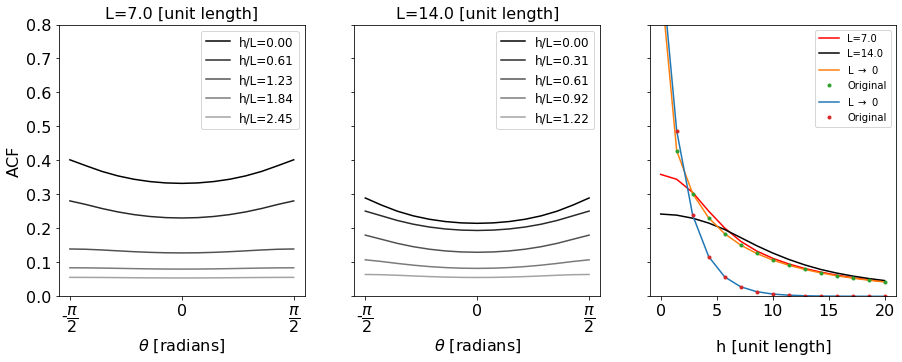

In [184]:
fs = 16
then = datetime.datetime.now()
pic = 0
factor = 2.0
eps = 0.0

# Define parameters
alpha = 2.0
beta = 1.0
gamma = 0.5
thetas = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20
phis = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20
L = 7.0
def make_hs():
    hs = np.linspace(0.01,20.0,15)#15
    return hs
hs = make_hs()

if printing:
    fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
Rr = compute_acf(hs,L,pic,printing)
pic += 1
maxy = np.nanmax(Rr) * 2
if printing:
    ax[2].plot(hs,Rr,'r',label='L=%.1f' %L)
    if full_expr is False:
        ax[0].set_xlabel(r'$\theta$ [radians]',fontsize=fs)
    else:
        ax[0].set_xlabel(r'$\theta$ [radians]',fontsize=fs)
    ax[0].set_ylabel('ACF',fontsize=fs)
#     ax[0].legend()
    ax[0].set_title('L=%.1f [unit length]' %L,fontsize=fs)

L = L * factor
Rr = compute_acf(hs,L,pic,printing)
if printing:
    ax[2].plot(hs,Rr,'k',label='L=%.1f' %L)
    if full_expr is False:
        ax[1].set_xlabel(r'$\theta$ [radians]',fontsize=fs)
    else:
        ax[1].set_xlabel(r'$\theta$ [radians]',fontsize=fs)
    ax[1].legend()
    ax[1].set_title('L=%.1f [unit length]' %L,fontsize=fs)
    ax[2].set_xlabel('h [unit length]',fontsize=fs)
combine_legend_subplots(0,xy=(1.0,1.0))
combine_legend_subplots(1,xy=(1.0,1.0))

### Sanity check 
L = 0.01
Rr = compute_acf(hs,L,printing=False)
maxy = np.nanmin((np.nanmax(Rr),maxy))
if printing:
    ax[2].plot(hs,Rr,'C1',label=r'L $\rightarrow$ 0')

Rr_orig = []
for h in hs:
    temp = acf_original_gamma(h, alpha, beta, gamma)
    Rr_orig.append(temp)
Rr_orig = np.array(Rr_orig)
if printing:
    ax[2].plot(hs,Rr_orig,'.C2',label='Original')
    ax[2].legend()
########################
########################
gamma = 1.0
L = 0.01
Rr = compute_acf(hs,L,printing=False)
maxy = np.nanmin((np.nanmax(Rr),maxy))
if printing:
    ax[2].plot(hs,Rr,'C0',label=r'L $\rightarrow$ 0')
Rr_orig = []
for h in hs:
    temp = acf_original_gamma(h, alpha, beta, gamma)
    Rr_orig.append(temp)
Rr_orig = np.array(Rr_orig)
if printing:
    ax[2].plot(hs,Rr_orig,'.C3',label='Original')
    ax[2].legend()
########################
########################

ax[0].set_xticks([-np.pi/2.0,0.0,np.pi/2.0])
ax[1].set_xticks([-np.pi/2.0,0.0,np.pi/2.0])
ax[0].set_xticklabels([r'-$\dfrac{\pi}{2}$', '0', r'$\dfrac{\pi}{2}$'])
ax[1].set_xticklabels([r'-$\dfrac{\pi}{2}$', '0', r'$\dfrac{\pi}{2}$'])
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
ax[2].tick_params(labelsize=fs);
ax[2].xaxis.set_label_coords(10.5+(hs[0]-hs[-1])/2, -0.16) # (hs[0]-hs[-1])/2
# ax[2].set_ylim(0,maxy)
ax[2].set_ylim(0,0.8)
print(datetime.datetime.now() - then)
# fig.savefig(my_path.joinpath('theta_and_phi' + str(full_expr) + '.png'), bbox_inches='tight')

### Plot the full and simplified expressions one on top of the other

In [23]:
my_path


PosixPath('/home/adameshel/Documents/code/autocorr/TRY')

L short done
L long done
L short done
L long done
0:09:00.667820


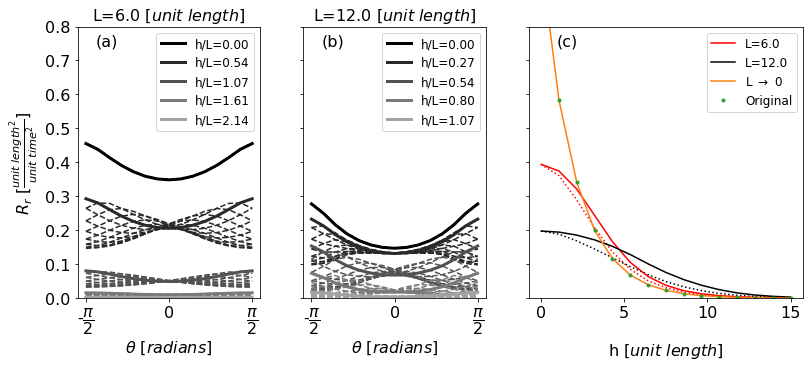

In [268]:
fs = 16
then = datetime.datetime.now()
pic = 0
factor = 2.0
eps = 0.0

# Define parameters
alpha = 2.0
beta = 1.0
thetas = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20
phis = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20

def make_hs():
    hs = np.linspace(0.01,15.0,15)#15
    return hs
hs = make_hs()
fig, ax = plt.subplots(1,3, figsize=(13,5), sharey=True,
                      gridspec_kw={'width_ratios': [2, 2, 3]})
for k in range(2):
    if k==0:
        full_expr = True
    else:
        full_expr = False
    L = 6.0
    #####################
    avgs = []
    i = 0; j = 0
    c = np.linspace(0.0,1.2,int(len(hs)/3)+1)
    for h in hs:
        acf_theta, avg = Rr_ang(h,L,thetas,phis,full_expr=full_expr) 
        avgs.append(avg)
        if printing and i%3==0:
            temp = h/L
            col = (c[j]/1.5, c[j]/1.5, c[j]/1.5)
            j += 1
            if full_expr==True:
                ax[0].plot(thetas, acf_theta, color=col, ls='--')
            else:
                ax[0].plot(thetas, acf_theta, color=col, 
                           linewidth=3, label='h/L=%.2f' %temp)
        i += 1
        ##################
    avgs = np.array(avgs)
    maxy = np.nanmax(avgs) * 2
    if full_expr == True:
        ax[2].plot(hs,avgs,'r',ls='dotted')
    else:
        ax[2].plot(hs,avgs,'r' ,label='L=%.1f' %L)
    if full_expr is False:
        ax[0].set_xlabel(r'$\theta$ [$radians$]',fontsize=fs)
    else:
        ax[0].set_xlabel(r'$\theta$ [$radians$]',fontsize=fs)
    ax[0].set_ylabel('$R_r$ [$\\frac{unit~length^2}{unit~time^2}$]',
                     fontsize=fs)
#     ax[0].legend()
    ax[0].set_title('L=%.1f [$unit~length$]' %L,fontsize=fs)
    print('L short done')
    L = L * factor
    #####################
    avgs = []
    i = 0; j = 0
    c = np.linspace(0.0,1.2,int(len(hs)/3)+1)
    for h in hs:
        acf_theta, avg = Rr_ang(h,L,thetas,phis,full_expr=full_expr) 
        avgs.append(avg)
        if printing and i%3==0:
            temp = h/L
#             temp = h
            col = (c[j]/1.5, c[j]/1.5, c[j]/1.5)
            j += 1
            if full_expr==True:
                ax[1].plot(thetas, acf_theta, color=col, ls='--')
            else:
                ax[1].plot(thetas, acf_theta, color=col,
                           linewidth=3, label='h/L=%.2f' %temp)
        i += 1
        ##################
    avgs = np.array(avgs)
    if full_expr == True:
        ax[2].plot(hs,avgs,'k',ls='dotted')
    else:
        ax[2].plot(hs,avgs,'k',label='L=%.1f' %L)
    if full_expr is False:
        ax[1].set_xlabel(r'$\theta$ [$radians$]',fontsize=fs)
    else:
        ax[1].set_xlabel(r'$\theta$ [$radians$]',fontsize=fs)
    print('L long done')
ax[1].legend()
ax[1].set_title('L=%.1f [$unit~length$]' %L,fontsize=fs)
ax[2].set_xlabel('h [$unit~length$]',fontsize=fs)
combine_legend_subplots(0,xy=(1.0,1.0),location='upper right')
combine_legend_subplots(1,xy=(1.0,1.0),location='upper right')
    
### Sanity check 
L = 0.01
#####################
avgs = []
i = 0; j = 0
c = np.linspace(0.0,1.2,int(len(hs)/3)+1)
for h in hs:
    acf_theta, avg = Rr_ang(h,L,thetas,phis,full_expr=full_expr) 
    avgs.append(avg)
    i += 1
    ##################
avgs = np.array(avgs)
maxy = np.nanmin((np.nanmax(avgs),maxy))

ax[2].plot(hs,avgs,'C1',label=r'L $\rightarrow$ 0')

Rr_orig = []
for h in hs:
    temp = acf_original(h, alpha, beta)
    Rr_orig.append(temp)
Rr_orig = np.array(Rr_orig)

ax[2].plot(hs,Rr_orig,'.C2',label='Original')
ax[2].legend(fontsize=12)

ax[0].set_xticks([-np.pi/2.0,0.0,np.pi/2.0])
ax[1].set_xticks([-np.pi/2.0,0.0,np.pi/2.0])
ax[0].set_xticklabels([r'-$\dfrac{\pi}{2}$', '0', r'$\dfrac{\pi}{2}$'])
ax[1].set_xticklabels([r'-$\dfrac{\pi}{2}$', '0', r'$\dfrac{\pi}{2}$'])
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
ax[2].tick_params(labelsize=fs);
ax[2].xaxis.set_label_coords(0.5, -0.16) # (hs[0]-hs[-1])/2
# ax[2].set_ylim(0,maxy)
ax[2].set_ylim(0,0.8)
strs_l = ['(a)','(b)','(c)']
for i in range(len(strs_l)):
    ax[i].text(0.1, 0.93, strs_l[i], 
                 fontsize=fs, 
                 color='k',
                 transform=ax[i].transAxes);
print(datetime.datetime.now() - then)
fig.savefig(my_path.joinpath('theta_and_phi_full_expr_both' + '.png'), bbox_inches='tight')
fig.savefig(fig_path.joinpath('theta_and_phi_full_expr_both' + '.png'), bbox_inches='tight')

[13.5584799   5.07731099  1.70140926]
[11.64530884  5.70383593]


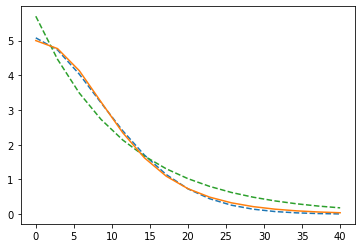

In [6]:
def make_hs():
    hs = np.linspace(0.01,40.0,15)#15
    return hs
hs = make_hs()
fs = 16
pic = 0
factor = 2.0
eps = 0.0
thetas = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20
phis = np.linspace(-np.pi/2+eps, np.pi/2-eps, 15)#20

L = 15.0; alpha = 7.0; beta = 10.0;# gamma = 2.5; 
Rr = compute_acf(hs,L,printing=False)
popt, pcov = curve_fit(f=acf_original_gamma, 
                       xdata=hs, 
                       ydata=Rr,
                       p0=[1,1,1],
                    bounds=[0,(1e4,np.inf,7)])
alpha1_opt, beta1_opt, gamma1_opt = popt
print(popt)

popt, pcov = curve_fit(f=acf_original, 
                       xdata=hs, 
                       ydata=Rr)
alpha2_opt, beta2_opt, = popt
print(popt)
fig, ax = plt.subplots()
ax.plot(hs,acf_original_gamma(hs,alpha1_opt,beta1_opt,gamma1_opt), '--C0')
ax.plot(hs,acf_original(hs,alpha2_opt,beta2_opt), '--C2')
ax.plot(hs, Rr, 'C1')

In [17]:
Ls = np.linspace(0.01,20.0,5)
    
Rr_mat = np.zeros((len(Ls),len(hs)))
total_time = datetime.datetime.now() - datetime.datetime.now()
for i,L in enumerate(Ls):
    then = datetime.datetime.now()
    print(L)
    Rr_mat[i,:] = compute_acf(hs, L)
    now = datetime.datetime.now()
    diff = now-then
    print('diff=%s' % diff)
    total_time += diff
    print('total=%s' % total_time)
    print('\n')

## Pickle data
data = [Ls, hs, Rr_mat, alpha, beta]
with open(my_path.joinpath('Ls_hs_Rrmat_a_%ib_%i' %(alpha,beta) + str(full_expr) + '.dat'), 'wb') as f:
    pkl.dump(len(data), f)
    for var in data:
        pkl.dump(var, f)
f.close()

0.01
diff=0:00:00.761592
total=0:00:00.761590


5.007499999999999
diff=0:00:02.671619
total=0:00:03.433209


10.004999999999999
diff=0:00:06.865036
total=0:00:10.298245


15.0025
diff=0:00:12.140025
total=0:00:22.438270


20.0
diff=0:00:16.490064
total=0:00:38.928334




### Restore pickled data

In [684]:
my_path = Path('/home/adameshel/Documents/code/autocorr/simple_large_run/')
data2 = []
alpha = 5; beta = 1;
with open(my_path.joinpath('Ls_hs_Rrmat_a_%ib_%i' %(alpha,beta) + str(full_expr) + '.dat'), 'rb') as f:
    for _ in range(pkl.load(f)):
        data2.append(pkl.load(f))
f.close()
Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; alpha=data2[3]; beta=data2[4]
print('alpha is %.3f' %alpha)
print('beta is %.3f' %beta)

alpha is 5.000
beta is 1.850


### Restore pickled data from newer dirs

In [139]:
my_path = Path('/home/adameshel/Documents/code/autocorr/with_gamma_big/')
# my_path = Path('/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific/')
files  = os.listdir(my_path)
file = np.random.choice(files,1)[0]
while 'Ls_' not in file:
    file = np.random.choice(files,1)[0]
print(file)
data2 = []

with open(my_path.joinpath(file), 'rb') as f:
    for _ in range(pkl.load(f)):
        data2.append(pkl.load(f))
f.close()
Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; alpha=data2[3]; beta=data2[4]
print('alpha is %.3f' %alpha)
print('beta is %.3f' %beta)

Ls_hs_Rrmat_a_2411b_850False.dat
alpha is 24.118
beta is 8.500


alpha is 5.000
beta is 8.500
/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific


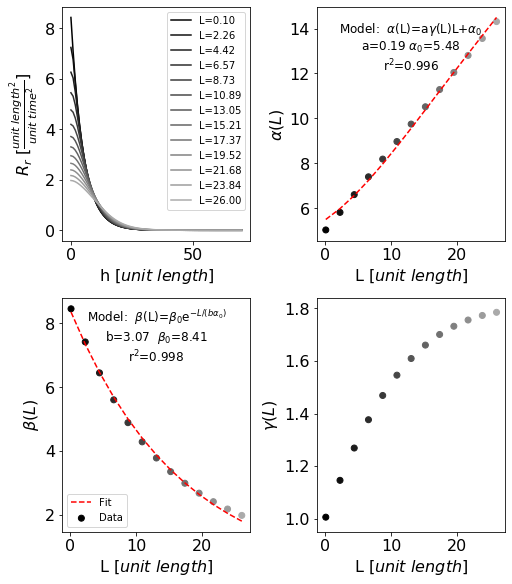

In [63]:
gamma_in = True
wls = False

fs = 16
fig, ax = plt.subplots(2,2,figsize=(7,8), constrained_layout=True)
alphas, betas, gammas = alpha_beta_gamma(hs, Rr_mat, Ls, printing=False)
sigma = np.ones_like(alphas)
if wls==True:
    sigma[0] = 1/1e3
if gamma_in==False:
    g_in = np.ones_like(gammas)
else:
    g_in = gammas
c = np.linspace(0.0,1.0,len(Rr_mat[:,0]))
for i in range(len(Rr_mat[:,0])):
    gs = np.array([c[i]/1.5, c[i]/1.5, c[i]/1.5])
    l = 'L=%.2f' %Ls[i]
    ax[0,0].plot(hs,Rr_mat[i],color=gs,label=l)
    ax[0,0].legend()

gs = [str(i/1.5) for i in c]

ax[1,0].scatter(Ls,betas,c=gs,label='Data')
ax[0,1].scatter(Ls,alphas,c=gs)
ax[1,1].scatter(Ls,gammas,c=gs)

ax[0,0].set_xlabel('h [$unit~length$]',fontsize=fs)
ax[1,0].set_xlabel('L [$unit~length$]',fontsize=fs)
ax[0,1].set_xlabel('L [$unit~length$]',fontsize=fs)
ax[0,0].set_ylabel('$R_r$ [$\\frac{unit~length^2}{unit~time^2}$]',fontsize=fs)
ax[1,0].set_ylabel(r'$\beta(L)$',fontsize=fs)
ax[0,1].set_ylabel(r'$\alpha(L)$',fontsize=fs)
ax[1,1].set_xlabel('L [$unit~length$]',fontsize=fs)
ax[1,1].set_ylabel(r'$\gamma(L)$',fontsize=fs)

ax[0,0].tick_params(labelsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[1,1].tick_params(labelsize=fs)

# pgamma, _ = curve_fit(
#     f=gamma_L,
#     xdata=Ls,
#     ydata=gammas
# )#,bounds=[1,0], p0=[0.1])

# c1, c2 = pgamma
# print(pgamma)
# line = gamma_L(Ls, c1, c2)
# r2 = round(np.corrcoef(gammas,line)[1,0],3)**2
# ax[1,1].plot(Ls,line,'--r')
# ax[1,1].set_title(r'Model:''\n''  $\gamma$(L)=$c_1$L$^{c_2}$ + $\gamma_0$'
#                 '\n'r'$c_1$=%.2f $c_2$=%.2f  ''\n''$\gamma_0$=%.2f r$^2$=%.3f' %(c1, c2, 1, r2),
#                  fontsize=fs-4, y=0.0);

palpha, _ = curve_fit(
    f=alpha_L,
    xdata=np.array([Ls,g_in]),
    ydata=alphas,
    sigma=sigma
)

a, alpha_0 = palpha
# alpha_0 = alpha_0_hat*
line = alpha_L(np.array([Ls,g_in]), a, alpha_0)
r2 = round(np.corrcoef(alphas,line)[1,0],3)**2
ax[0,1].plot(Ls,line,'--r')
ax[0,1].set_title(r'Model:  $\alpha$(L)=a$\gamma$(L)L+$\alpha_0$'
                '\n'r'a=%.2f $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2),
                 fontsize=fs-4, y=0.7)
# ax[2].set_title(r'Model:  $\alpha(L)=$$\alpha_0$e$^{L/(a\alpha_0)}$'
#                 '\n'r'a=%.2f  $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2))

pbeta, _ = curve_fit(
    f=beta_L,
    xdata=Ls,
    ydata=betas,
    sigma=sigma,
    p0=[3,1],
    bounds=[0, (10, np.inf)]
)
b, beta_0 = pbeta
line = beta_L(Ls, b, beta_0)
r2 = round(np.corrcoef(betas,line)[1,0],3)**2
ax[1,0].plot(Ls,line,'--r',label='Fit')
ax[1,0].set_title(r'Model:  $\beta$(L)=$\beta_0$e$^{-L/(b\alpha_0)}$'
                '\n'r'b=%.2f  $\beta_0$=%.2f''\n''r$^2$=%.3f' %(b, beta_0, r2),
                 fontsize=fs-4, y=0.7);
ax[1,0].legend(loc="lower left")
print('alpha is %.3f' %alpha)
print('beta is %.3f' %beta)
print(my_path)
# fig.savefig(my_path.joinpath('figures/alpha%i_beta%i_gamma' %(alpha*10,beta*10)\
#                              + str(full_expr) + '.png'), bbox_inches='tight')
# fig.savefig(fig_path.joinpath('alpha%i_beta%i_gamma' %(alpha*10,beta*10)\
#                              + str(full_expr) + '.png'), bbox_inches='tight')

### Full and simple expressions on the same plot

In [119]:
gamma_in = True
wls = True

/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific
Ls_hs_Rrmat_a_2411b_700True.dat
0.998001
0.996004
alpha is 24.118
beta is 7.000
/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific
/home/adameshel/Documents/code/autocorr/with_gamma_big
Ls_hs_Rrmat_a_2411b_700False.dat
0.998001
0.994009
alpha is 24.118
beta is 7.000
/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific


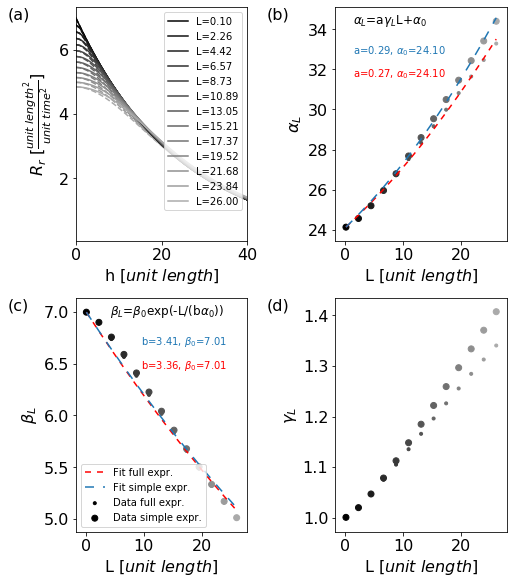

In [144]:
xloc = 0.1; yloc = 0.8
fs = 16
fig, ax = plt.subplots(2,2,figsize=(7,8), constrained_layout=True)
paths = [Path('/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific/'),
         Path('/home/adameshel/Documents/code/autocorr/with_gamma_big/')]
for p,path in enumerate(paths):
    print(path)
    if '_True' in str(path):
        full = True
    else:
        full = False
    files  = os.listdir(path)
    file = np.random.choice(files,1)[0]
    if full==False:
        while fn not in file: #Ls_hs_Rrmat_a_500b_850
            file = np.random.choice(files,1)[0]
    else:
        fn = split_at(file,'True.',1)[0]
        while 'Ls_' not in file: #Ls_hs_Rrmat_a_500b_850
            file = np.random.choice(files,1)[0]
            fn = split_at(file,'True.',1)[0]
    print(file)
    data2 = []

    with open(path.joinpath(file), 'rb') as f:
        for _ in range(pkl.load(f)):
            data2.append(pkl.load(f))
    f.close()
    Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; alpha=data2[3]; beta=data2[4]

    alphas, betas, gammas = alpha_beta_gamma(hs, Rr_mat, Ls, printing=False)
    sigma = np.ones_like(alphas)
    if wls==True:
        sigma[0] = 1/1e3
    if gamma_in==False:
        g_in = np.ones_like(gammas)
    else:
        g_in = gammas
    c = np.linspace(0.0,1.0,len(Rr_mat[:,0]))
    for i in range(len(Rr_mat[:,0])):
        gs = np.array([c[i]/1.5, c[i]/1.5, c[i]/1.5])
        l = 'L=%.2f' %Ls[i]
        if full==False:
            ax[0,0].plot(hs,Rr_mat[i],color=gs,label=l)
            ax[0,0].legend(loc='upper right')
        else:
            ax[0,0].plot(hs,Rr_mat[i],color=gs,ls='--')
#             ax[0,0].legend()
            
    ax[0,0].set_xlim((0,40))
    gs = [str(i/1.5) for i in c]
    if full==False:
        ax[1,0].scatter(Ls,betas,c=gs,label='Data simple expr.')
        ax[0,1].scatter(Ls,alphas,c=gs)
        ax[1,1].scatter(Ls,gammas,c=gs)
    else:
        ax[1,0].scatter(Ls,betas,c=gs,marker='.',label='Data full expr.')
        ax[0,1].scatter(Ls,alphas,c=gs,marker='.')
        ax[1,1].scatter(Ls,gammas,c=gs,marker='.')

    ax[0,0].set_xlabel('h [$unit~length$]',fontsize=fs)
    ax[1,0].set_xlabel('L [$unit~length$]',fontsize=fs)
    ax[0,1].set_xlabel('L [$unit~length$]',fontsize=fs)
    ax[0,0].set_ylabel('$R_r$ [$\\frac{unit~length^2}{unit~time^2}$]',fontsize=fs)
    ax[1,0].set_ylabel(r'$\beta_L$',fontsize=fs)
    ax[0,1].set_ylabel(r'$\alpha_L$',fontsize=fs)
    ax[1,1].set_xlabel('L [$unit~length$]',fontsize=fs)
    ax[1,1].set_ylabel(r'$\gamma_L$',fontsize=fs)

    ax[0,0].tick_params(labelsize=fs)
    ax[1,0].tick_params(labelsize=fs)
    ax[0,1].tick_params(labelsize=fs)
    ax[1,1].tick_params(labelsize=fs)

    # pgamma, _ = curve_fit(
    #     f=gamma_L,
    #     xdata=Ls,
    #     ydata=gammas
    # )#,bounds=[1,0], p0=[0.1])

    # r, c2 = pgamma
    # print(pgamma)
    # line = gamma_L(Ls, r, c2)
    # r2 = round(np.corrcoef(gammas,line)[1,0],3)**2
    # ax[1,1].plot(Ls,line,'--r')
    # ax[1,1].set_title(r'Model:''\n''  $\gamma_L$=$c_1$L$^{c_2}$ + $\gamma_0$'
    #                 '\n'r'$c_1$=%.2f $c_2$=%.2f  ''\n''$\gamma_0$=%.2f r$^2$=%.3f' %(r, c2, 1, r2),
    #                  fontsize=fs-4, y=0.0);

    palpha, _ = curve_fit(
        f=alpha_L,
        xdata=np.array([Ls,g_in]),
        ydata=alphas,
        sigma=sigma
    )

    a, alpha_0 = palpha
    # alpha_0 = alpha_0_hat*
    line = alpha_L(np.array([Ls,g_in]), a, alpha_0)
    r2 = round(np.corrcoef(alphas,line)[1,0],3)**2
    print(r2)
    if full==False:
        ax[0,1].plot(Ls,line,'--C0', dashes=(6, 6))
        ax[0,1].text(xloc,yloc,r'a=%.2f, $\alpha_0$=%.2f' %(a, alpha_0),
                    fontsize=fs-6, 
                     color='C0',
                     transform=ax[0,1].transAxes)
    else:
        ax[0,1].plot(Ls,line,'--r', dashes=(4, 4))
        ax[0,1].text(xloc,yloc-0.1,r'a=%.2f, $\alpha_0$=%.2f' %(a, alpha_0),
                    fontsize=fs-6, 
                     color='r',
                     transform=ax[0,1].transAxes)
#     ax[0,1].set_title(r'Model:  $\alpha_L$=a$\gamma_L$L+$\alpha_0$'
#                     '\n'r'a=%.2f $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2),
#                      fontsize=fs-4, y=0.7)
    
    # ax[2].set_title(r'Model:  $\alpha_L=$$\alpha_0$e$^{L/(a\alpha_0)}$'
    #                 '\n'r'a=%.2f  $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2))

    pbeta, _ = curve_fit(
        f=beta_L,
        xdata=Ls,
        ydata=betas,
        sigma=sigma,
        p0=[3,1],
        bounds=[0, (10, np.inf)]
    )
    b, beta_0 = pbeta
    line = beta_L(Ls, b, beta_0)
    r2 = round(np.corrcoef(betas,line)[1,0],3)**2
    print(r2)
    if full==False:
        ax[1,0].plot(Ls,line,'-C0',dashes=(6, 6),label='Fit simple expr.')
        ax[1,0].text(xloc+0.28,yloc,r'b=%.2f, $\beta_0$=%.2f' %(b, beta_0),
            fontsize=fs-6, 
             color='C0',
             transform=ax[1,0].transAxes)
    else:
        ax[1,0].plot(Ls,line,'--r',dashes=(4, 4),label='Fit full expr.')
        ax[1,0].text(xloc+0.28,yloc-0.1,r'b=%.2f, $\beta_0$=%.2f' %(b, beta_0),
            fontsize=fs-6, 
             color='r',
             transform=ax[1,0].transAxes)
#     ax[1,0].set_title(r'Model:  $\beta_L$=$\beta_0$e$^{-L/(b\alpha_0)}$'
#                     '\n'r'b=%.2f  $\beta_0$=%.2f''\n''r$^2$=%.3f' %(b, beta_0, r2),
#                      fontsize=fs-4, y=0.7);
    ax[1,0].legend(loc="lower left")
    print('alpha is %.3f' %alpha)
    print('beta is %.3f' %beta)
    print(my_path)

ax[0,0].text(-0.4, 0.95, '(a)', fontsize=fs, color='k',transform=ax[0,0].transAxes);
ax[0,1].text(-0.4, 0.95, '(b)', fontsize=fs, color='k',transform=ax[0,1].transAxes);
ax[1,0].text(-0.4, 0.95, '(c)', fontsize=fs, color='k',transform=ax[1,0].transAxes);
ax[1,1].text(-0.4, 0.95, '(d)', fontsize=fs, color='k',transform=ax[1,1].transAxes);

ax[0,1].text(0.1, 0.93, r'$\alpha_L$=a$\gamma_L$L+$\alpha_0$', 
             fontsize=fs-4, 
             color='k',
             transform=ax[0,1].transAxes);
ax[1,0].text(0.2, 0.93, r'$\beta_L$=$\beta_0$exp(-L/(b$\alpha_0$))', 
             fontsize=fs-4, 
             color='k',
             transform=ax[1,0].transAxes);
plt.show()
fig.savefig(fig_path.joinpath('joined_alpha%i_beta%i_gamma' %(alpha*10,beta*10)\
                             + str(full_expr) + '.png'), bbox_inches='tight')

In [76]:
pbeta

array([0.02957602, 8.50195989])

In [145]:
np.nanmax(Rr_mat)

2.498679317030961

Text(0.5, 1.0, 'Model:  $\\beta$(L)=$\\beta_0$e$^{-L/(b\\alpha_0)}$\nb=4.10  $\\beta_0$=5.01\nr$^2$=1.000')

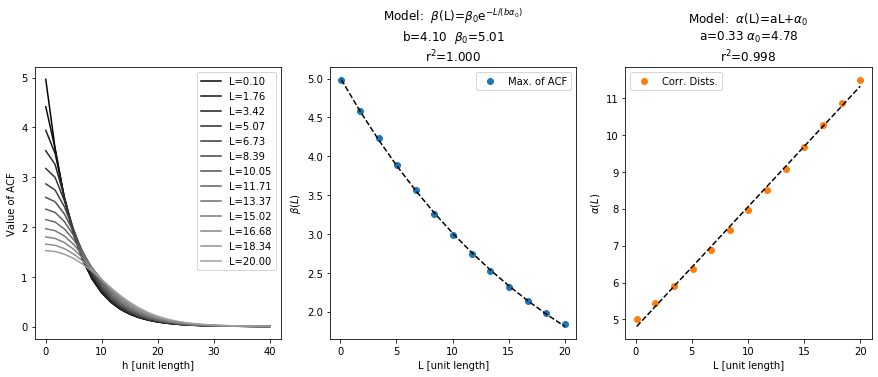

In [11]:
# betas = np.array(s_l)
# alphas = np.array(hc_l)
fig, ax = plt.subplots(1,3,figsize=(15,5))
alphas, betas = alpha_beta(hs, Rr_mat, Ls, alpha_beta_95=alpha_beta_95, printing=True)

ax[1].scatter(Ls,betas,c='C0',label='Max. of ACF')
ax[1].legend()
ax[2].scatter(Ls,alphas,c='C1',label='Corr. Dists.')
ax[2].legend()

ax[0].set_xlabel('h [unit length]')
ax[1].set_xlabel('L [unit length]')
ax[2].set_xlabel('L [unit length]')
ax[0].set_ylabel('Value of ACF')
ax[1].set_ylabel(r'$\beta(L)$')
ax[2].set_ylabel(r'$\alpha(L)$')

palpha, _ = curve_fit(f=alpha_L,xdata=Ls,ydata=alphas)
a, alpha_0 = palpha
line = alpha_L(Ls, a, alpha_0)
r2 = round(np.corrcoef(alphas,line)[0,1],3)**2
ax[2].plot(Ls,line,'--k')
ax[2].set_title(r'Model:  $\alpha$(L)=aL+$\alpha_0$'
                '\n'r'a=%.2f $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2))
# ax[2].set_title(r'Model:  $\alpha(L)=$$\alpha_0$e$^{L/(a\alpha_0)}$'
#                 '\n'r'a=%.2f  $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(a, alpha_0, r2))

pbeta, _ = curve_fit(f=beta_L,xdata=Ls,ydata=betas)
b, beta_0 = pbeta
line = beta_L(Ls, b, beta_0)
r2 = round(np.corrcoef(betas,line)[0,1],3)**2
ax[1].plot(Ls,line,'--k')
ax[1].set_title(r'Model:  $\beta$(L)=$\beta_0$e$^{-L/(b\alpha_0)}$'
                '\n'r'b=%.2f  $\beta_0$=%.2f''\n''r$^2$=%.3f' %(b, beta_0, r2))
fig.savefig(my_path.joinpath('alpha%i_beta%i_' %(alpha*10,beta*10) + str(full_expr) + '.png'), 
            bbox_inches='tight')

In [32]:
# my_path = Path('/home/adameshel/Documents/code/autocorr/with_gamma/')
data2 = []
file = glob.glob(str(my_path.joinpath('as_*.dat')))
with open(file[0], 'rb') as f:
    for _ in range(pkl.load(f)):
        data2.append(pkl.load(f))
f.close()
set_of_alphas = data2[0]
set_of_betas = data2[1]

### In case there was a distributed run and you want to gather results in one dir
This is only for the `as_and_bsFalse.dat` file. The rest should be transfered manually.

In [223]:
gamma_list_of_lists = []
set_of_alphas = np.array([]); set_of_betas = np.array([]);
a_all = []; b_all = [];
r2a_all = []; r2b_all = [];
for i in range(2):
    data_current = []
    dr = Path('/home/adameshel/Documents/code/autocorr/' + 'with_gamma%s/' %str(i+1))
    file = glob.glob(str(dr.joinpath('as_*.dat')))
    with open(file[0], 'rb') as f:
        for _ in range(pkl.load(f)):
            data_current.append(pkl.load(f))
    f.close()
    if i==0:
        Ls = data_current[6]
    set_of_alphas = np.append(set_of_alphas, data_current[0])
    set_of_betas = np.append(set_of_betas, data_current[1])
    print(data_current[2])
    print(np.shape(data_current[2]))
    a_all.append(data_current[2].tolist())
    b_all.append(data_current[3].tolist())
    r2a_all.append(data_current[4].tolist())
    r2b_all.append(data_current[5].tolist())
    for j in range(np.shape(data_current[7])[0]):
        gamma_list_of_lists.append(data_current[7][j])
a_all = np.concatenate(a_all)
b_all = np.concatenate(b_all)
r2a_all = np.concatenate(r2a_all)
r2b_all = np.concatenate(r2b_all)

# data = [set_of_alphas, set_of_betas, a_all, b_all, r2a_all, r2b_all, Ls, gamma_list_of_lists]
# dr = Path('/home/adameshel/Documents/code/autocorr/' + 'with_gamma_big_True_specific/')
# with open(dr.joinpath('as_and_bsTrue.dat'), 'wb') as f:
#     pkl.dump(len(data), f)
#     for var in data:
#         pkl.dump(var, f)
# f.close()

[[0.61620844 0.61089572 0.61623296 0.61086584 0.61623319]
 [0.54151101 0.54150915 0.54150907 0.54150907 0.54150908]
 [0.51290852 0.51290785 0.51290784 0.51290783 0.51290782]
 [0.49350039 0.49349981 0.49349983 0.49349982 0.4934998 ]
 [0.48038466 0.48038444 0.48038442 0.48038442 0.48038443]]
(5, 5)
[[0.4718479  0.4718479  0.47184789 0.47184789 0.4718479 ]
 [0.46472495 0.46472496 0.46472498 0.46472497 0.46472494]
 [0.4590542  0.45905417 0.45905419 0.45905415 0.45905419]
 [0.45423775 0.45423772 0.45423773 0.45423775 0.45423776]
 [0.44989084 0.4498908  0.44989081 0.44989081 0.44989088]]
(5, 5)


In [225]:
np.shape(a_all)

(10, 5)

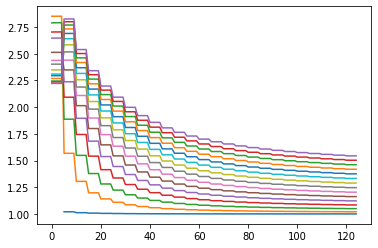

In [168]:
plt.plot(gamma_list_of_lists)

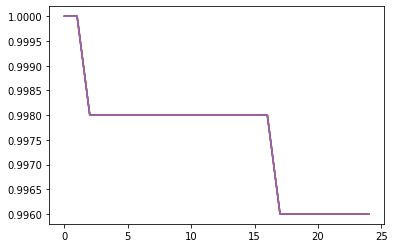

In [177]:
plt.plot(r2a_all)

### Read directory where there are files from a big run

In [145]:
my_path = Path('/home/adameshel/Documents/code/autocorr/with_gamma_big/')
data2 = []
file = glob.glob(str(my_path.joinpath('as_*.dat')))
with open(file[0], 'rb') as f:
    for _ in range(pkl.load(f)):
        data2.append(pkl.load(f))
f.close()
set_of_alphas = data2[0]
set_of_betas = data2[1]

print('a       ','b     ','alpha', 'alpha_0','beta', 'beta_0')
a_all = []
b_all = [] 
c1_all = []
c2_all = []
alpha_0_all = []
beta_0_all = []
alpha_all = []
beta_all = []

files = sorted(glob.glob(str(my_path.joinpath('Ls*.dat'))))
for i, file in enumerate(files):
    data2 = []
    with open(file, 'rb') as f:
        for _ in range(pkl.load(f)):
            data2.append(pkl.load(f))
    f.close()
    
    Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; 
    alpha=data2[3]; beta=data2[4];
    
    alphas, betas, gammas = alpha_beta_gamma(
        hs, 
        Rr_mat, 
        Ls,  
        printing=False
    )
    alphas, betas, gammas, Ls = exclude_nans(alphas, betas, gammas, Ls)
    ## for weighted least squares
    sigma = np.ones_like(alphas)
    if wls==True:
        sigma[0] = 1/1e5
    
#     pgamma, _ = curve_fit(
#         f=gamma_L,
#         xdata=Ls,
#         ydata=gammas
#     )#,bounds=[0,1], p0=[0.1])
#     c1, c2 = pgamma
#     c1_all.append(c1)
#     c2_all.append(c2)
#     line = gamma_L(Ls, c1, c2)
#     r2c = round(np.corrcoef(gammas,line)[0,1],3)**2
    palpha, erra = curve_fit(
        f=alpha_L,
        xdata=np.array([Ls,gammas]),
        ydata=alphas,
        sigma=sigma
    )
    a, alpha_0 = palpha
    a_all.append(a)
    line = alpha_L(np.array([Ls,gammas]), a, alpha_0)
    r2a = round(np.corrcoef(alphas,line)[0,1],3)**2
    try:
        pbeta, errb = curve_fit(
            f=beta_L,
            xdata=Ls,
            ydata=betas,
            sigma=sigma,
            p0=[3,1],
            bounds=[0, (10, np.inf)]
        )
    except:
        pbeta, errb = curve_fit(
            f=beta_L,
            xdata=Ls,
            ydata=betas,
            p0=[3,1],
            bounds=[0, (10, np.inf)]
        )
    b, beta_0 = pbeta
    line = beta_L(Ls, b, beta_0)
    r2b = round(np.corrcoef(betas,line)[0,1],3)**2
    if r2a < 0.9 or r2b < 0.9:
        print(r2a, r2b)
    b_all.append(b)
    print(round(a,6),round(b,6), round(alpha,3), round(alpha_0,3), 
          round(beta,3), round(beta_0,3))#, round(c1,3), round(c2,3))
    alpha_0_all.append(alpha_0)
    beta_0_all.append(beta_0)
    alpha_all.append(alpha)
    beta_all.append(beta)
a_all = np.array(a_all); alpha_0_all = np.array(alpha_0_all); alpha_all = np.array(alpha_all);
b_all = np.array(b_all); beta_0_all = np.array(beta_0_all); beta_all = np.array(beta_all);
# c1_all = np.array(c1_all); c2_all = np.array(c2_all);

print('\n')
change_of_b = abs((np.nanmax(b_all)-np.nanmin(b_all)))/np.nanmax(b_all)*1e2
change_of_a = abs((np.nanmax(a_all)-np.nanmin(a_all)))/np.nanmax(a_all)*1e2

# print('Relative change of a is %.3f percent' %(change_of_a/change_of_alpha*1e2))
# print('Relative change of b is %.3f percent' %(change_of_b/change_of_alpha*1e2))
# print('Change of a with alpha is %.3f percent' %(abs((a_all[0]-a_all[-1]))/abs((0.5-5.0))*1e2))
# print('Change of b with alpha is %.3f percent' %(abs((b_all[0]-b_all[-1]))/abs((0.5-5.0))*1e2))

df = pd.DataFrame({'a': a_all,
                   'b': b_all,
                   'alpha': alpha_all,
                   'alpha_0': alpha_0_all,
                   'beta': beta_all,
                   'beta_0': beta_0_all})
df = df.sort_values(by='alpha')
df.reset_index(inplace=True,drop=True)

set_of_alpha_0 = []
for i,alpha in enumerate(set_of_alphas):
    temp = df.where(df.alpha==alpha).dropna()
    set_of_alpha_0.append(temp.alpha_0.values[0])
set_of_alpha_0 = np.array(set_of_alpha_0)

set_of_beta_0 = []
for i,beta in enumerate(set_of_betas):
    temp = df.where(df.beta==beta).dropna()
    set_of_beta_0.append(temp.beta_0.values[0])
set_of_beta_0 = np.array(set_of_beta_0)

a        b      alpha alpha_0 beta beta_0
0.271413 3.246321 12.647 12.638 10.0 10.013
0.271413 3.246321 12.647 12.638 1.0 1.001
0.271413 3.246321 12.647 12.638 2.5 2.503
0.271413 3.246321 12.647 12.638 4.0 4.005
0.271413 3.246321 12.647 12.638 5.5 5.507
0.271413 3.246321 12.647 12.638 7.0 7.009
0.271413 3.246321 12.647 12.638 8.5 8.511
0.281968 3.305429 16.471 16.458 10.0 10.011
0.281968 3.30543 16.471 16.458 1.0 1.001
0.281968 3.305429 16.471 16.458 2.5 2.503
0.281968 3.30543 16.471 16.458 4.0 4.004
0.281968 3.305429 16.471 16.458 5.5 5.506
0.281968 3.305429 16.471 16.458 7.0 7.008
0.281968 3.305429 16.471 16.458 8.5 8.509
0.286112 3.364451 20.294 20.279 10.0 10.009
0.286112 3.364453 20.294 20.279 1.0 1.001
0.286112 3.364454 20.294 20.279 2.5 2.502
0.286112 3.364453 20.294 20.279 4.0 4.004
0.286112 3.364453 20.294 20.279 5.5 5.505
0.286112 3.364452 20.294 20.279 7.0 7.007
0.286112 3.364454 20.294 20.279 8.5 8.508
0.286146 3.414928 24.118 24.101 10.0 10.008
0.286146 3.414929 24.118 24.

$\alpha_0$=$\alpha$+(-0.014)
$\beta_0$=$\beta$+(0.008)


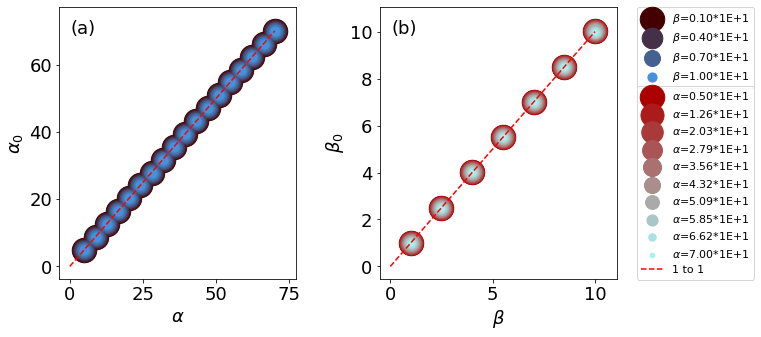

In [146]:
fs = 18
fig, ax = plt.subplots(1,2, figsize=(10,5))
markersize = 600

l_alpha = np.linspace(0,np.max(set_of_alphas),len(set_of_alphas))
l_beta = np.linspace(0,np.max(set_of_betas),len(set_of_betas))
ax[0].plot(l_alpha,l_alpha,'--r')
ax[1].plot(l_beta,l_beta,'--r',label='1 to 1')

ms = np.ceil(markersize/len(set_of_alphas))
c = np.linspace(0.0,1.0,len(set_of_alphas)+1)
for i, alpha in enumerate(set_of_alphas):
    df_temp = df.where(df.alpha==alpha).dropna()
    df_temp.sort_values(by='beta', inplace=True)
    betas_temp = df_temp.beta.values
    beta_0s = df_temp.beta_0.values
    gs = np.array([[1.0/1.5, c[i]/1.0, c[i]/1.0]])
    if np.mod(i,2) == 0 or i==len(set_of_alphas)-1:
        l = alpha/10.0
        label = r'$\alpha$=%.2f*1E+1' %l
        ax[1].scatter(betas_temp,beta_0s,c=gs,label=label,s=markersize-ms*i)
    else:
        ax[1].scatter(betas_temp,beta_0s,c=gs,s=markersize-ms*i)
ms = np.ceil(markersize/len(set_of_betas))
c = np.linspace(0.0,1.0,len(set_of_betas)+1)
for i, beta in enumerate(set_of_betas):
    df_temp = df.where(df.beta==beta).dropna()
    df_temp.sort_values(by='alpha', inplace=True)
    alphas_temp = df_temp.alpha.values
    alpha_0s = df_temp.alpha_0.values
    gs = np.array([[0.4/1.5, c[i]/1.5, c[i]/1.0]])
    if np.mod(i,2) == 0 or i==len(set_of_betas)-1:
        l = beta/10.0
        label = r'$\beta$=%.2f*1E+1' %l
        ax[0].scatter(alphas_temp,alpha_0s,c=gs,label=label,s=markersize-ms*i)
    else:
        ax[0].scatter(alphas_temp,alpha_0s,c=gs,s=markersize-ms*i)
        
## bias correction
bias_alpha, _ = curve_fit(f=bias,xdata=set_of_alphas,ydata=set_of_alpha_0)
print(r'$\alpha_0$=$\alpha$+(%.3f)' %bias_alpha)
bias_beta, _ = curve_fit(f=bias,xdata=set_of_betas,ydata=set_of_beta_0)
print(r'$\beta_0$=$\beta$+(%.3f)' %bias_beta)

lgd0 = combine_legend_subplots(0, xy=(2.95, 1.02), fs=11)
lgd1 = combine_legend_subplots(1, xy=(1.6,0.73),fs=11)#xy=(2.13,1.01)
ax[0].set_ylabel(r'$\alpha_0$',fontsize=fs); ax[1].set_ylabel(r'$\beta_0$',fontsize=fs);
ax[0].set_xlabel(r'$\alpha$',fontsize=fs); ax[1].set_xlabel(r'$\beta$',fontsize=fs);
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
ax[0].text(0.05, 0.9, '(a)', fontsize=fs, color='k',transform=ax[0].transAxes);
ax[1].text(0.05, 0.9, '(b)', fontsize=fs, color='k',transform=ax[1].transAxes);
# fig.align_ylabels()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
fig.savefig(my_path.joinpath('figures/prediction.png'), 
            bbox_extra_artists=(lgd0,lgd1), 
            bbox_inches='tight')
fig.savefig(fig_path.joinpath('prediction.png'), 
            bbox_extra_artists=(lgd0,lgd1), 
            bbox_inches='tight')

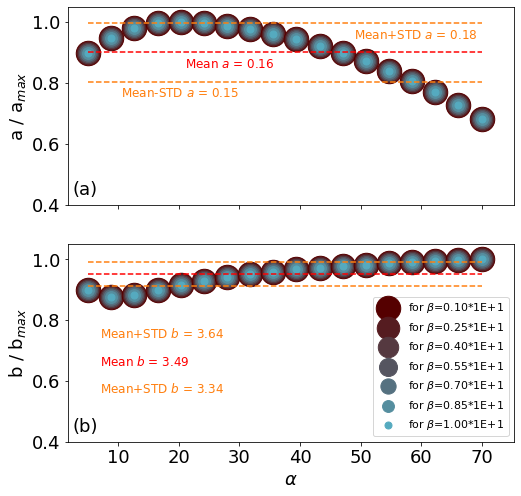

In [29]:
fs = 18
fig, ax = plt.subplots(2,1, figsize=(8,8),sharex=True)
amax = df.a.max()
bmax = df.b.max()
a_l = []; b_l = []
markersize = 600
# ms = np.ceil(markersize/len(set_of_betas))
ms = np.ceil(markersize/df.beta.unique().max() * 0.9) 
c = np.linspace(0.0,1.0,df.beta.unique().max()+1)
for i, alpha in enumerate(set_of_alphas):
    df_temp = df.where(df.alpha==alpha).dropna()
    df_temp.beta.values.sort()
    a_l.append(df_temp.a.values[0])
    b_l.append(df_temp.b.values[0])
    for j, beta in enumerate(df_temp.beta.values):
        temp_betas_sorted = df.beta.unique().sort()
        idx = np.where(np.sort(df.beta.unique()) == beta)[0][0]
#         np.array([[0.5/1.5, c[idx]/1.0, c[idx]/1.0]])
        gs = np.array([[0.5/1.5, c[idx]/0.9, c[idx]/0.8]])
        l = beta/10.0
        label = r'for $\beta$=%.2f*1E+1' %l
        power = 1.0

        ax[0].scatter(df_temp.alpha.values[j],
                      df_temp.a.values[j]/amax,
                      c=gs,
                      label=label,
                      s = markersize-ms*c[idx]*17
                     )
        ax[1].scatter(df_temp.alpha.values[j],
                      df_temp.b.values[j]/bmax,
                      c=gs, 
                      label=label,
                      s = markersize-ms*c[idx]*17
                     )

ax[0].set_ylabel(r'a / a$_{max}$',fontsize=fs); ax[1].set_ylabel(r'b / b$_{max}$',fontsize=fs);
ax[1].set_xlabel(r'$\alpha$',fontsize=fs);# ax[0].set_xlabel(r'$\alpha$',fontsize=fs)
ax[0].set_ylim(0,1.1); ax[1].set_ylim(0,1.1)

a_arr = np.array(a_l); b_arr = np.array(b_l)
amean = np.nanmean(a_arr); bmean = np.nanmean(b_arr)
astd = np.std(a_arr); bstd = np.std(b_arr)

aline = np.ones(len(set_of_alphas)) * amean
ax[0].plot(set_of_alphas,aline/amax,'--r')
ax[0].text(0.3*np.max(set_of_alphas), 
           amean/amax-0.05,
           r'Mean $a$ = %.2f' %amean,
           color='r',
           fontsize=12
          )
alinestd = aline-astd
ax[0].plot(set_of_alphas,alinestd/amax,'--C1')
ax[0].text(0.15*np.max(set_of_alphas), 
           (amean-astd)/amax-0.05,
           r'Mean-STD $a$ = %.2f' %(amean-astd),
           color='C1',
           fontsize=12
          )
alinestd = aline+astd
ax[0].plot(set_of_alphas,alinestd/amax,'--C1')
ax[0].text(0.7*np.max(set_of_alphas) , 
           (amean+astd)/amax-0.05,
           r'Mean+STD $a$ = %.2f' %(amean+astd),
           color='C1',
           fontsize=12
          )


bline = np.ones(len(set_of_alphas)) * bmean
ax[1].text(0.1*np.max(set_of_alphas), 
           bmean/bmax-0.25-0.05,
           r'Mean $b$ = %.2f' %bmean,
           color='r',
           fontsize=12
          )
ax[1].plot(set_of_alphas,bline/bmax,'--r')
blinestd = bline+bstd
ax[1].plot(set_of_alphas,blinestd/bmax,'--C1')
ax[1].text(0.1*np.max(set_of_alphas) , 
           (bmean+bstd)/bmax-0.25,
           r'Mean+STD $b$ = %.2f' %(bmean+bstd),
           color='C1',
           fontsize=12
          )
blinestd = bline-bstd
ax[1].plot(set_of_alphas,blinestd/bmax,'--C1')
ax[1].text(0.1*np.max(set_of_alphas) , 
           (bmean-bstd)/bmax-0.25-0.1,
           r'Mean+STD $b$ = %.2f' %(bmean-bstd),
           color='C1',
           fontsize=12
          )

# yt = ax[0].get_yticks() 
# yt = np.append(yt,round(amean/amax,2))
# ax[0].set_yticks(yt)
# yt = ax[1].get_yticks()
# yt = np.append(yt,round(bmean/bmax,2))
# ax[1].set_yticks(yt)
ax[0].set_ylim(0.4,1.05); ax[1].set_ylim(0.4,1.05)
# lgd = combine_legend_subplots(0,xy=(1.3, 1.01),fs=11)
lgd = combine_legend_subplots(1,xy=(1, 0),fs=11, location='lower right')
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
ax[0].text(0.01, 0.05, '(a)', fontsize=fs, color='k',transform=ax[0].transAxes);
ax[1].text(0.01, 0.05, '(b)', fontsize=fs, color='k',transform=ax[1].transAxes);
# fig.savefig(my_path.joinpath('figures/a_b.png'),
#             bbox_extra_artists=(lgd,), 
#             bbox_inches='tight')
# fig.savefig(fig_path.joinpath('a_b.png'),
#             bbox_extra_artists=(lgd,), 
#             bbox_inches='tight')

a        b      alpha alpha_0 beta beta_0
0.271413 3.246321 12.647 12.638 10.0 10.013
0.271413 3.246321 12.647 12.638 1.0 1.001
0.271413 3.246321 12.647 12.638 2.5 2.503
0.271413 3.246321 12.647 12.638 4.0 4.005
0.271413 3.246321 12.647 12.638 5.5 5.507
0.271413 3.246321 12.647 12.638 7.0 7.009
0.271413 3.246321 12.647 12.638 8.5 8.511
0.281968 3.305429 16.471 16.458 10.0 10.011
0.281968 3.30543 16.471 16.458 1.0 1.001
0.281968 3.305429 16.471 16.458 2.5 2.503
0.281968 3.30543 16.471 16.458 4.0 4.004
0.281968 3.305429 16.471 16.458 5.5 5.506
0.281968 3.305429 16.471 16.458 7.0 7.008
0.281968 3.305429 16.471 16.458 8.5 8.509
0.286112 3.364451 20.294 20.279 10.0 10.009
0.286112 3.364453 20.294 20.279 1.0 1.001
0.286112 3.364454 20.294 20.279 2.5 2.502
0.286112 3.364453 20.294 20.279 4.0 4.004
0.286112 3.364453 20.294 20.279 5.5 5.505
0.286112 3.364452 20.294 20.279 7.0 7.007
0.286112 3.364454 20.294 20.279 8.5 8.508
0.286146 3.414928 24.118 24.101 10.0 10.008
0.286146 3.414929 24.118 24.

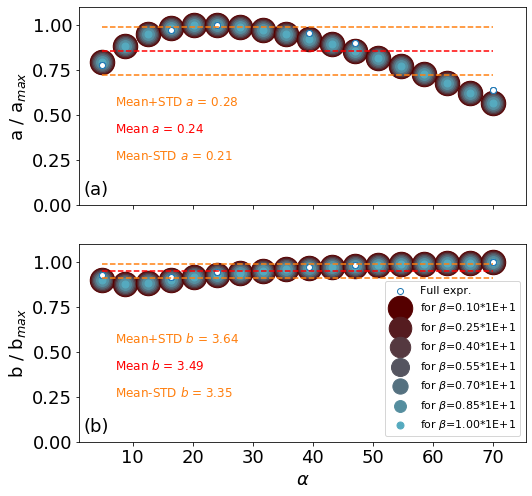

In [151]:
my_paths = [Path('/home/adameshel/Documents/code/autocorr/with_gamma_big/'),
            Path('/home/adameshel/Documents/code/autocorr/with_gamma_big_True_specific/')]
fs = 18
fig, ax = plt.subplots(2,1, figsize=(8,8),sharex=True)

for _, my_path in enumerate(my_paths):
    if '_True' in str(my_path):
        full = True
    else:
        full = False
        
    data2 = []
    file = glob.glob(str(my_path.joinpath('as_*.dat')))
    with open(file[0], 'rb') as f:
        for _ in range(pkl.load(f)):
            data2.append(pkl.load(f))
    f.close()
    set_of_alphas = data2[0]
    set_of_betas = data2[1]

    print('a       ','b     ','alpha', 'alpha_0','beta', 'beta_0')
    a_all = []
    b_all = [] 
    c1_all = []
    c2_all = []
    alpha_0_all = []
    beta_0_all = []
    alpha_all = []
    beta_all = []

    files = sorted(glob.glob(str(my_path.joinpath('Ls*.dat'))))
    for i, file in enumerate(files):
        data2 = []
        with open(file, 'rb') as f:
            for _ in range(pkl.load(f)):
                data2.append(pkl.load(f))
        f.close()

        Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; 
        alpha=data2[3]; beta=data2[4];

        alphas, betas, gammas = alpha_beta_gamma(
            hs, 
            Rr_mat, 
            Ls,  
            printing=False
        )
        alphas, betas, gammas, Ls = exclude_nans(alphas, betas, gammas, Ls)
        ## for weighted least squares
        sigma = np.ones_like(alphas)
        if wls==True:
            sigma[0] = 1/1e5

    #     pgamma, _ = curve_fit(
    #         f=gamma_L,
    #         xdata=Ls,
    #         ydata=gammas
    #     )#,bounds=[0,1], p0=[0.1])
    #     c1, c2 = pgamma
    #     c1_all.append(c1)
    #     c2_all.append(c2)
    #     line = gamma_L(Ls, c1, c2)
    #     r2c = round(np.corrcoef(gammas,line)[0,1],3)**2
        palpha, erra = curve_fit(
            f=alpha_L,
            xdata=np.array([Ls,gammas]),
            ydata=alphas,
            sigma=sigma
        )
        a, alpha_0 = palpha
        a_all.append(a)
        line = alpha_L(np.array([Ls,gammas]), a, alpha_0)
        r2a = round(np.corrcoef(alphas,line)[0,1],3)**2
        try:
            pbeta, errb = curve_fit(
                f=beta_L,
                xdata=Ls,
                ydata=betas,
                sigma=sigma,
                p0=[3,1],
                bounds=[0, (10, np.inf)]
            )
        except:
            pbeta, errb = curve_fit(
                f=beta_L,
                xdata=Ls,
                ydata=betas,
                p0=[3,1],
                bounds=[0, (10, np.inf)]
            )
        b, beta_0 = pbeta
        line = beta_L(Ls, b, beta_0)
        r2b = round(np.corrcoef(betas,line)[0,1],3)**2
        if r2a < 0.9 or r2b < 0.9:
            print(r2a, r2b)
        b_all.append(b)
        print(round(a,6),round(b,6), round(alpha,3), round(alpha_0,3), 
              round(beta,3), round(beta_0,3))#, round(c1,3), round(c2,3))
        alpha_0_all.append(alpha_0)
        beta_0_all.append(beta_0)
        alpha_all.append(alpha)
        beta_all.append(beta)
    a_all = np.array(a_all); alpha_0_all = np.array(alpha_0_all); alpha_all = np.array(alpha_all);
    b_all = np.array(b_all); beta_0_all = np.array(beta_0_all); beta_all = np.array(beta_all);
    # c1_all = np.array(c1_all); c2_all = np.array(c2_all);

    print('\n')
    change_of_b = abs((np.nanmax(b_all)-np.nanmin(b_all)))/np.nanmax(b_all)*1e2
    change_of_a = abs((np.nanmax(a_all)-np.nanmin(a_all)))/np.nanmax(a_all)*1e2

    # print('Relative change of a is %.3f percent' %(change_of_a/change_of_alpha*1e2))
    # print('Relative change of b is %.3f percent' %(change_of_b/change_of_alpha*1e2))
    # print('Change of a with alpha is %.3f percent' %(abs((a_all[0]-a_all[-1]))/abs((0.5-5.0))*1e2))
    # print('Change of b with alpha is %.3f percent' %(abs((b_all[0]-b_all[-1]))/abs((0.5-5.0))*1e2))

    df = pd.DataFrame({'a': a_all,
                       'b': b_all,
                       'alpha': alpha_all,
                       'alpha_0': alpha_0_all,
                       'beta': beta_all,
                       'beta_0': beta_0_all})
    df = df.sort_values(by='alpha')
    df.reset_index(inplace=True,drop=True)

    set_of_alpha_0 = []
    for i,alpha in enumerate(set_of_alphas):
        temp = df.where(df.alpha==alpha).dropna()
        set_of_alpha_0.append(temp.alpha_0.values[0])
    set_of_alpha_0 = np.array(set_of_alpha_0)

    set_of_beta_0 = []
    for i,beta in enumerate(set_of_betas):
        temp = df.where(df.beta==beta).dropna()
        set_of_beta_0.append(temp.beta_0.values[0])
    set_of_beta_0 = np.array(set_of_beta_0)

    amax = df.a.max()
    bmax = df.b.max()
    a_l = []; b_l = []
    markersize = 600
    # ms = np.ceil(markersize/len(set_of_betas))
    ms = np.ceil(markersize/df.beta.unique().max() * 0.9) 
    c = np.linspace(0.0,1.0,df.beta.unique().max()+1)
    for i, alpha in enumerate(set_of_alphas):
        df_temp = df.where(df.alpha==alpha).dropna()
        df_temp.beta.values.sort()
        a_l.append(df_temp.a.values[0])
        b_l.append(df_temp.b.values[0])
        for j, beta in enumerate(df_temp.beta.values):
            temp_betas_sorted = df.beta.unique().sort()
            idx = np.where(np.sort(df.beta.unique()) == beta)[0][0]
    #         np.array([[0.5/1.5, c[idx]/1.0, c[idx]/1.0]])
            gs = np.array([[0.5/1.5, c[idx]/0.9, c[idx]/0.8]])
            l = beta/10.0
            label = r'for $\beta$=%.2f*1E+1' %l
            power = 1.0
            if full is False:
                ax[0].scatter(df_temp.alpha.values[j],
                              df_temp.a.values[j]/amax,
                              c=gs,
                              label=label,
                              s = markersize-ms*c[idx]*17
                             )
                ax[1].scatter(df_temp.alpha.values[j],
                              df_temp.b.values[j]/bmax,
                              c=gs, 
                              label=label,
                              s = markersize-ms*c[idx]*17
                             )
            else:
#                 my_greys = np.ones(np.shape(df_temp.alpha.values[j]))*0.6
                ax[0].scatter(df_temp.alpha.values[j],
                              df_temp.a.values[j]/amax,
                              c='w',
                              label='Full expr.',
                              edgecolors='C0'
                             )
                ax[1].scatter(df_temp.alpha.values[j],
                              df_temp.b.values[j]/bmax,
                              c='w', 
                              label='Full expr.',
                              edgecolors='C0'
                             )
                

    ax[0].set_ylabel(r'a / a$_{max}$',fontsize=fs); ax[1].set_ylabel(r'b / b$_{max}$',fontsize=fs);
    ax[1].set_xlabel(r'$\alpha$',fontsize=fs);# ax[0].set_xlabel(r'$\alpha$',fontsize=fs)
    ax[0].set_ylim(0,1.1); ax[1].set_ylim(0,1.1)
    
    if full is False:
        a_arr = np.array(a_l); b_arr = np.array(b_l)
        amean = np.nanmean(a_arr); bmean = np.nanmean(b_arr)
        astd = np.std(a_arr); bstd = np.std(b_arr)

        aline = np.ones(len(set_of_alphas)) * amean
        ax[0].plot(set_of_alphas,aline/amax,'--r')
        ax[0].text(0.1*np.max(set_of_alphas), 
                   0.55-0.15,
                   r'Mean $a$ = %.2f' %amean,
                   color='r',
                   fontsize=12
                  )
        
        alinestd = aline-astd
        ax[0].plot(set_of_alphas,alinestd/amax,'--C1')
        ax[0].text(0.1*np.max(set_of_alphas), 
                   0.55-0.3,
                   r'Mean-STD $a$ = %.2f' %(amean-astd),
                   color='C1',
                   fontsize=12
                  )
        alinestd = aline+astd
        ax[0].plot(set_of_alphas,alinestd/amax,'--C1')
        ax[0].text(0.1*np.max(set_of_alphas) , 
                   0.55,
                   r'Mean+STD $a$ = %.2f' %(amean+astd),
                   color='C1',
                   fontsize=12
                  )


        bline = np.ones(len(set_of_alphas)) * bmean
        ax[1].text(0.1*np.max(set_of_alphas), 
                   0.55-0.15,
                   r'Mean $b$ = %.2f' %bmean,
                   color='r',
                   fontsize=12
                  )
        ax[1].plot(set_of_alphas,bline/bmax,'--r')
        blinestd = bline+bstd
        ax[1].plot(set_of_alphas,blinestd/bmax,'--C1')
        ax[1].text(0.1*np.max(set_of_alphas) , 
                   0.55,
                   r'Mean+STD $b$ = %.2f' %(bmean+bstd),
                   color='C1',
                   fontsize=12
                  )
        blinestd = bline-bstd
        ax[1].plot(set_of_alphas,blinestd/bmax,'--C1')
        ax[1].text(0.1*np.max(set_of_alphas) , 
                   0.55-0.3,
                   r'Mean-STD $b$ = %.2f' %(bmean-bstd),
                   color='C1',
                   fontsize=12
                  )

    # yt = ax[0].get_yticks() 
    # yt = np.append(yt,round(amean/amax,2))
    # ax[0].set_yticks(yt)
    # yt = ax[1].get_yticks()
    # yt = np.append(yt,round(bmean/bmax,2))
    # ax[1].set_yticks(yt)

    # lgd = combine_legend_subplots(0,xy=(1.3, 1.01),fs=11)
    lgd = combine_legend_subplots(1,xy=(1, 0),fs=11, location='lower right')
# ax[0].set_ylim(0.4,1.05); ax[1].set_ylim(0.4,1.05)
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
ax[0].text(0.01, 0.05, '(a)', fontsize=fs, color='k',transform=ax[0].transAxes);
ax[1].text(0.01, 0.05, '(b)', fontsize=fs, color='k',transform=ax[1].transAxes);
# fig.savefig(my_path.joinpath('figures/a_b.png'),
#             bbox_extra_artists=(lgd,), 
#             bbox_inches='tight')
fig.savefig(fig_path.joinpath('a_b.png'),
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

In [155]:
(0.14/3.49)*100

4.011461318051576

In [54]:
np.max(set_of_alphas)

70.0

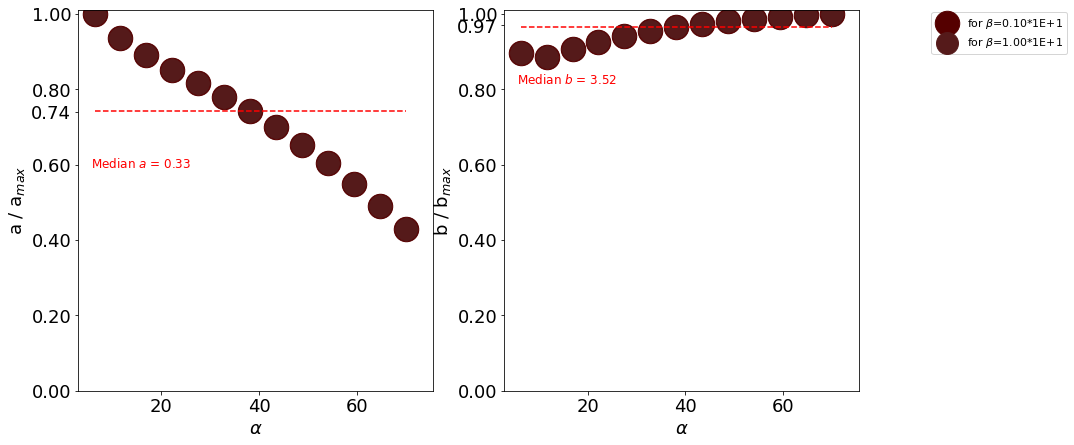

In [54]:
df_c = df.copy()
df_c = df_c.where(df_c.alpha >= 5).dropna()
df_c.reset_index(inplace=True,drop=True)
set_of_alphas_c = set_of_alphas[set_of_alphas >= 5]

fs = 18
fig, ax = plt.subplots(1,2, figsize=(14,7))
amax = df_c.a.max()
bmax = df_c.b.max()
a_l = []; b_l = []
markersize = 600
# ms = np.ceil(markersize/len(set_of_betas))
ms = np.ceil(markersize/df_c.beta.unique().max() * 0.9) 
c = np.linspace(0.0,1.0,df_c.beta.unique().max()+1)
for i, alpha in enumerate(set_of_alphas_c):
    df_temp = df_c.where(df_c.alpha==alpha).dropna()
    df_temp.beta.values.sort()
    a_l.append(df_temp.a.values[0])
    b_l.append(df_temp.b.values[0])
    for j, beta in enumerate(df_temp.beta.values):
        temp_betas_sorted = df_c.beta.unique().sort()
        idx = np.where(np.sort(df_c.beta.unique()) == beta)[0][0]
#         import pdb; pdb.set_trace()
        gs = np.array([[0.5/1.5, c[idx]/1.0, c[idx]/1.0]])
        l = beta/10.0
        label = r'for $\beta$=%.2f*1E+1' %l
        power = 1
        ax[0].scatter(df_temp.alpha.values[j],
                      df_temp.a.values[j]**power/amax**power,
                      c=gs,
                      label=label,
                      s = markersize-ms*c[idx]*22)
        ax[1].scatter(df_temp.alpha.values[j],
                      df_temp.b.values[j]/bmax,
                      c=gs, 
                      s = markersize-ms*c[idx]*22)
#         print(beta, markersize-ms*c[idx]*20, idx)
#         if i==0:
#             break
#         if j==0:
#             break
a_arr = np.array(a_l); b_arr = np.array(b_l)
ax[0].set_ylabel(r'a / a$_{max}$',fontsize=fs); ax[1].set_ylabel(r'b / b$_{max}$',fontsize=fs);
ax[0].set_xlabel(r'$\alpha$',fontsize=fs); ax[1].set_xlabel(r'$\alpha$',fontsize=fs)
ax[0].set_ylim(0,1.01); ax[1].set_ylim(0,1.01)

amed = np.nanmedian(a_arr); bmed = np.nanmedian(b_arr)
# amed = df_c.a.median()
# bmed = df_c.b.median()
aline = np.ones(len(set_of_alphas_c)) * amed
bline = np.ones(len(set_of_alphas_c)) * bmed
ax[0].plot(set_of_alphas_c,aline/amax,'--r')
ax[0].text(5.5 , amed/amax-0.15,r'Median $a$ = %.2f' %amed,color='r',fontsize=12)
ax[1].text(5.5 , bmed/bmax-0.15,r'Median $b$ = %.2f' %bmed,color='r',fontsize=12)
ax[1].plot(set_of_alphas_c,bline/bmax,'--r')
# ax[0].set_yticks([1,amed/amax])
yt = ax[0].get_yticks() 
yt = np.append(yt,round(amed/amax,2))
ax[0].set_yticks(yt)
yt = ax[1].get_yticks()
yt = np.append(yt,round(bmed/bmax,2))
ax[1].set_yticks(yt)
ax[0].set_ylim(0,1.01); ax[1].set_ylim(0,1.01)
lgd = combine_legend_subplots(0,fs=11)
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
# fig.savefig(my_path.joinpath('figures/a_b_big_alphas.png'),
#             bbox_extra_artists=(lgd,), 
#             bbox_inches='tight')

In [50]:
num = 90
alpha = df.alpha.values[num]; 
beta = df.beta.values[num]; 
L = 15;
print(alpha,beta)

alpha_0med = alpha_L_inv(L,amed,alpha,bias=0.362)
beta_0med = beta_L_inv(L,bmed,beta,alpha_0med)
print(alpha_0med,beta_0med)

alpha_0 = alpha_L_inv(L,df.a.values[num],alpha,bias=0.362)
beta_0 = beta_L_inv(L,df.b.values[num],beta,alpha_0)
# alpha_0 = df.alpha_0.values[num]
# beta_0 = df.beta.values[num]
print(alpha_0,beta_0)
err = ((alpha_0-alpha_0med)/alpha_0) * 1e2
print('alpha error rate is %.3f percent' %err)
err = ((beta_0-beta_0med)/beta_0) * 1e2
print('beta error rate is %.3f percent' %err)

4.884615384615384 1.4285714285714286
-0.09981284678521785 1.0064826259188426e-15
-0.3991065639701644 0.00015181852783909268
alpha error rate is 74.991 percent
beta error rate is 100.000 percent


In [166]:
for i, L in enumerate(Ls):
    alpha_0med_all = []; beta_0med_all = []
    alpha_0_all = []; beta_0_all = []
    alpha_err = []; beta_err = []
    errs = []
    for num in range(len(df)):
        alpha = df.alpha.values[num]#/L; 
        beta = df.beta.values[num]#/L; 

        alpha_0med = alpha_L_inv(L,amed,alpha,bias=bias_alpha)#/L
        beta_0med = beta_L_inv(L,bmed,beta,alpha_0med)#/L
        alpha_0 = alpha_L_inv(L,df.a.values[num],alpha,bias=bias_alpha)#/L
        beta_0 = beta_L_inv(L,df.b.values[num],beta,alpha_0)#/L
        # alpha_0 = df.alpha_0.values[num]
        # beta_0 = df.beta.values[num]
        err1 = ((alpha_0-alpha_0med))#/alpha_0) * 1e2
#         alpha_err.append(err)
        alpha_0med_all.append(alpha_0med)
        alpha_0_all.append(alpha_0)
        err2 = ((beta_0-beta_0med))#/beta_0) * 1e2
#         if abs(err2) > 100:
#             import pdb; pdb.set_trace()
#         beta_err.append(err)
        beta_0med_all.append(beta_0med)
        beta_0_all.append(beta_0)
        errs.append((err1,err2))
    L_str = 'err_Lidx%i' %i
    df[L_str] = (errs)

In [167]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
c = np.linspace(0.0,1.0,len(set_of_alphas)+1)
c1 = np.linspace(0.4,0.0,len(set_of_alphas)+1)
for i,L in enumerate(Ls):
    alpha_err_list = []
    beta_err_list = []
    for _, alpha in enumerate(set_of_alphas):
        df_temp = df.where(df.alpha==alpha).dropna()
        row1 = df_temp.loc[df_temp.index[0]] # beta has no effect, therefore not taken
        L_str = 'err_Lidx%i' %i
        alpha_err_list.append(row1[L_str][0])
        beta_err_list.append(row1[L_str][1])
    alpha_err = np.array(alpha_err_list)
    beta_err = np.array(beta_err_list)
    gs = np.array([c1[i]/0.5, c[i]/0.5, c[i]/0.5])
    L_label = 'L=%.2f*1E+1' %(L/10.0)
    alpha_err[abs(alpha_err) > 10] = np.nan
    beta_err[abs(beta_err) > 10] = np.nan
    ax[0].plot(set_of_alphas, alpha_err, color=gs, label=L_label, linewidth=2.5)
    ax[1].plot(set_of_alphas, beta_err, color=gs, linewidth=2.5)
    
lgd = combine_legend_subplots(0, xy=(2.83,1.01), fs=11)
# ax[0].set_ylim(-200,200)
ax[0].set_ylim(-7.5,7.5)
ax[0].set_xlabel
ax[0].set_ylabel(r'Error in $\alpha_0$ [?]',fontsize=fs); 
ax[1].set_ylabel(r'Error in $\beta_0$ [?]',fontsize=fs);
ax[0].set_xlabel(r'$\alpha$',fontsize=fs); ax[1].set_xlabel(r'$\alpha$',fontsize=fs);
ax[0].tick_params(labelsize=fs); ax[1].tick_params(labelsize=fs);
fig.savefig(my_path.joinpath('figures/error.png'), 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

ValueError: RGBA values should be within 0-1 range

<Figure size 720x360 with 2 Axes>

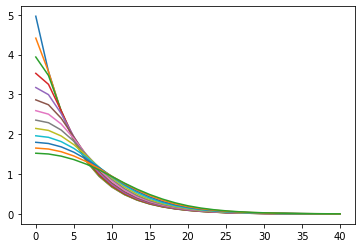

In [346]:
fig, ax = plt.subplots()
for i in range(len(Rr_mat[:,0])):
    ax.plot(hs,Rr_mat[i])

L	 Path	 Rr	 Rr_ang	 Rr_orig	 accml	 acf	 acf_original	 alpha	 
alpha_L	 alpha_L_inv	 alpha_beta	 alpha_beta_95	 ax	 beta	 beta_L	 beta_L_inv	 bias	 
combine_legend_subplots	 compute_acf	 curve_fit	 data2	 datetime	 dblquad	 eps	 factor	 fig	 
full_expr	 glob	 h	 hs	 make_hs	 my_path	 np	 nquad	 pd	 
phis	 pic	 pkl	 plt	 printing	 quad	 temp	 then	 thetas	 



In [75]:
rows = 2
cols = 2
Ls = np.linspace(0.5, 15.0, rows*cols)
hs = np.linspace(0.5, 20.0, 6)
ms_mat = np.zeros((len(Ls),len(hs)))
for i,L in enumerate(Ls):
    print(L)
    ms = []
    for h in hs:
        Rr, m = Rr_ang(h,L) # long
        ms.append(m)
    ms_mat[i,:] = np.array(ms)

0.5
5.333333333333333
10.166666666666666
15.0


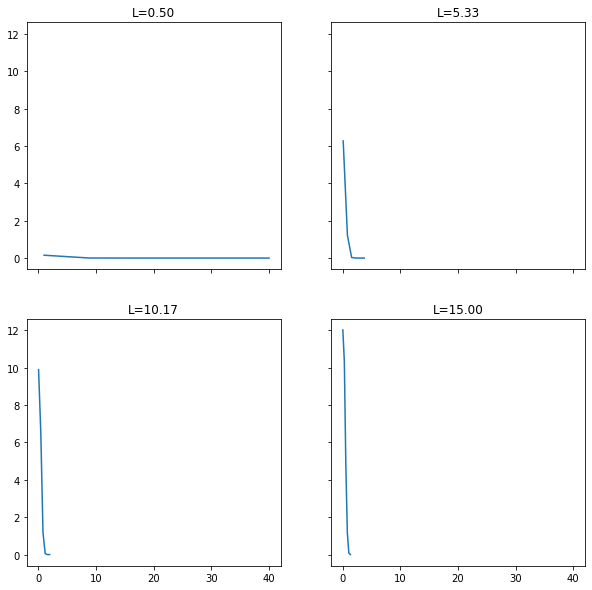

In [82]:
fig, ax = plt.subplots(rows, cols, figsize=(10,10), sharey=True, sharex=True)
l=0
for r in range(rows):
    for c in range(cols):
        ax[r,c].plot(hs/Ls[l], ms_mat[l])
        ax[r,c].set_title('L=%.2f' %Ls[l])
        l += 1


Text(0, 0.5, 'f')

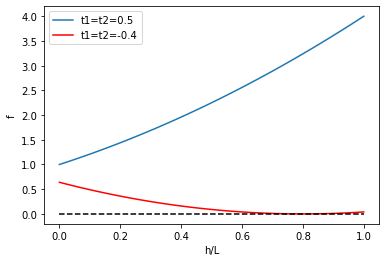

In [28]:
theta = -np.pi/2
L = 10
hs = np.linspace(0,10,70)
t2 = 0.5
t1 = t2
sq = []
def f(t1,t2,h,L,theta):
    '''The expression under the square root'''
    return (t2+(h/L))**2 + t1**2 -2*t1*(t2+(h/L))*np.sin(theta)
for h in hs:
    sq.append(f(t1,t2,h,L,theta))
sq = np.array(sq)
plt.plot(hs/L,sq,label='t1=t2=%.1f' %t1)

sq = []
t2 = -0.4
t1 = t2
for h in hs:
    sq.append(f(t1,t2,h,L,theta))
sq = np.array(sq)
plt.plot(hs/L,sq,'r',label='t1=t2=%.1f' %t1)
plt.plot(hs/L,sq*0,'--k')
plt.legend()
plt.xlabel('h/L')
plt.ylabel('f')